(Naive) stock price prediction program using LSTM recurrent neural networks, licensed under the [Apache License, Version 2.0](http://www.apache.org/licenses/LICENSE-2.0)

# General libraries
We start by importing the main libraires we shall use:

- the [numpy](https://numpy.org/) library (for arrays operations)
- the [pandas](https://pandas.pydata.org/) library (for data analysis)
- the [matplotlib.pyplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html) interface (for MATLAB-like plots)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset preparation
We retrieve Netflix stock prices from Jan 04, 2010 to May 23, 2022 ("NFLX.csv") from [finance.yahoo.com](https://finance.yahoo.com/quote/NFLX/history).

In [2]:
# Storing the data in DataFrame "df"

df = pd.read_csv('NFLX.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.931429,7.961429,7.565714,7.640000,7.640000,17239600
1,2010-01-05,7.652857,7.657143,7.258571,7.358571,7.358571,23753100
2,2010-01-06,7.361429,7.672857,7.197143,7.617143,7.617143,23290400
3,2010-01-07,7.731429,7.757143,7.462857,7.485714,7.485714,9955400
4,2010-01-08,7.498571,7.742857,7.465714,7.614286,7.614286,8180900
...,...,...,...,...,...,...,...
3114,2022-05-17,189.169998,191.399994,185.169998,190.559998,190.559998,9876700
3115,2022-05-18,186.720001,187.699997,176.270004,177.190002,177.190002,9665600
3116,2022-05-19,178.050003,186.300003,175.710007,183.479996,183.479996,10448500
3117,2022-05-20,185.869995,190.190002,179.770004,186.350006,186.350006,10422600


In [3]:
# Storing "Close" values of stock prices in a numpy array "arr", and reshaping it into a vertical array

arr = df['Close'].values.reshape(-1, 1)
print('\033[1m' + 'arr.shape:' + '\033[0m', arr.shape)

arr.shape: (3119, 1)


In [4]:
# Splitting the data into a training set stored in array "train_arr" (first 90% of the rows of "arr")
# And a test set stored in array "test_arr" (last 10% of the rows of "arr")
# Storing in list "dates" the dates corresponding to "test_arr"

train_arr = arr[:int(arr.shape[0]*0.9)]
test_arr = arr[int(arr.shape[0]*0.9):]
dates = df['Date'].tolist()[int(arr.shape[0]*0.9):]

print('\033[1m' + 'train_arr.shape:' + '\033[0m', train_arr.shape)
print('\033[1m' + 'test_arr.shape:' + '\033[0m', test_arr.shape)
print('\033[1m' + 'len(dates):' + '\033[0m', len(dates))

train_arr.shape: (2807, 1)
test_arr.shape: (312, 1)
len(dates): 312


We import the estimator [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from the sklearn.preprocessing module to rescale the data to a given range, typically the interval [0,1]. We rescale with MinMaxScaler the training data and, in order to avoid any [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning%29) and [look-ahead bias](https://www.investopedia.com/terms/l/lookaheadbias.asp), we use the same scaling parameters to rescale the test data.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_arr = scaler.fit_transform(train_arr)
test_arr = scaler.transform(test_arr)

We define a function "create_sequences" which creates two numpy arrays "sequences" and "labels" given an array "arr" and a number of time steps "n". The 1D numpy array labels contains all the last values of arr, starting from the n-th value. The 2D numpy array sequences contains all the sequences of n consecutive values of arr.

In [6]:
def create_sequences(arr, n):
    sequences, labels = [], []
    for i in range(n, arr.shape[0]):
        sequences.append(arr[i-n: i, 0])
        labels.append(arr[i, 0])
    return np.array(sequences), np.array(labels)

In [7]:
# Setting a number of time steps n
# Using the function create_sequences to create the training set and test set for the model
# Storing in "dates" the list of dates corresponding to test_labels

n = 30
train_seqs, train_labels = create_sequences(train_arr, n)
test_seqs, test_labels = create_sequences(test_arr, n)
dates = dates[n:]

print('\033[1m' + 'train_seqs.shape:' + '\033[0m', train_seqs.shape)
print('\033[1m' + 'train_labels.shape:' + '\033[0m', train_labels.shape)
print('\033[1m' + 'test_seqs.shape:' + '\033[0m', test_seqs.shape)
print('\033[1m' + 'test_labels.shape:' + '\033[0m', test_labels.shape)
print('\033[1m' + 'len(dates):' + '\033[0m', len(dates))

train_seqs.shape: (2777, 30)
train_labels.shape: (2777,)
test_seqs.shape: (282, 30)
test_labels.shape: (282,)
len(dates): 282


In [8]:
# Reshaping train_seqs and test_seqs into the 3D array needed for the LSTM input layer of the model
# The 3D array includes: number of rows, number of time steps and number of features (here 1 for "Close" values)

train_seqs = np.reshape(train_seqs, (train_seqs.shape[0], train_seqs.shape[1], 1))
test_seqs = np.reshape(test_seqs, (test_seqs.shape[0], test_seqs.shape[1], 1))

print('\033[1m' + 'train_seqs.shape:' + '\033[0m', train_seqs.shape)
print('\033[1m' + 'test_seqs.shape:' + '\033[0m', test_seqs.shape)

train_seqs.shape: (2777, 30, 1)
test_seqs.shape: (282, 30, 1)


# RNN model
We start by importing some classes and functions from Keras:

- the [Sequential](https://keras.io/api/models/sequential/) class from the keras.models API (to group a linear stack of layers into a model)
- the [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/) class from the keras.layers API (to apply a long short-term memory layer to an input)
- the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) class from the keras.layers API (to apply dropout to the input)
- the [Dense](https://keras.io/api/layers/core_layers/dense/) class from the keras.layers API (to apply a regular densely-connected NN layer to an input)

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

We define a RNN model which takes as input the stock prices of n consecutive days and gives as output a prediction of stock price at day n+1:

- we set the class of the model as Sequential.
- we add an LSTM layer with units_ℓ output units (with option "return_sequences=True" to set the output as a 3D array)
- we add a Dropout layer with frequency rate r_ℓ
- we add an LSTM layer with units_ℓ output units (with option "return_sequences=True" to set the output as a 3D array)
- we add a Dropout layer with frequency rate r_ℓ
- we add an LSTM layer with units_ℓ output units
- we add a Dropout layer with frequency rate r_d
- we add a Dense layer with 1 output unit (the dimension of 1 stock price prediction)

In [10]:
units_ℓ = 128
r_ℓ = 0.2
r_d = 0.4

model = Sequential()
model.add(LSTM(units=units_ℓ, return_sequences=True, input_shape=(n, 1)))
model.add(Dropout(r_ℓ))
model.add(LSTM(units=units_ℓ, return_sequences=True))
model.add(Dropout(r_ℓ))
model.add(LSTM(units=units_ℓ))
model.add(Dropout(r_d))
model.add(Dense(units=1))

We give a summary of the model using the [summary](https://keras.io/api/models/model/#summary-method) method of the model class of Keras. The "None" value stands for the (not yet defined) value of the batch size.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

We import the [plot_model](https://keras.io/api/utils/model_plotting_utils/) function from the [keras.utils.vis_utils](https://faroit.com/keras-docs/2.0.8/visualization/) module to plot a schema of the model.

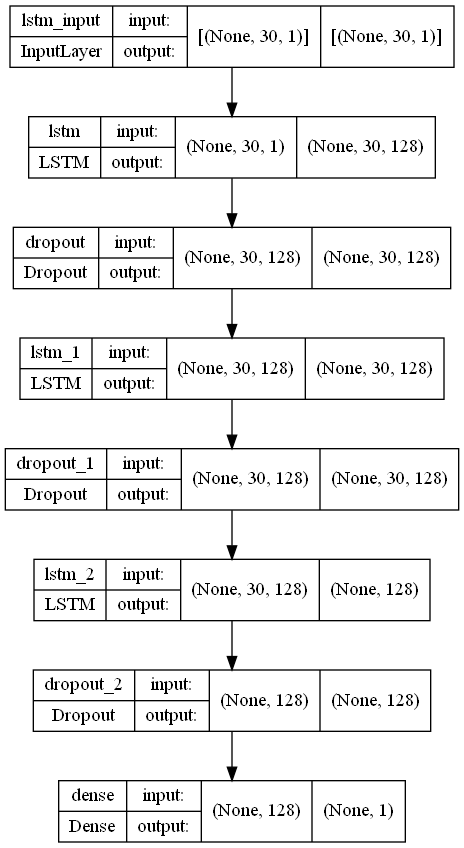

In [12]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We configure (compile) the model for training with the following parameters:

- [adam](https://keras.io/api/optimizers/adam) as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)
- [mean square error](https://keras.io/api/losses/regression_losses/#meansquarederror-class) (mse) between labels and predictions as quantity to minimise during training process
- [root mean absolute error](https://keras.io/api/metrics/regression_metrics/#rootmeansquarederror-class) between labels and predictions as metric to display during training process

In [13]:
model.compile(optimizer='adam', loss='mse', metrics='RootMeanSquaredError')

We [train the model](https://keras.io/api/models/model_training_apis/#fit-method) with a given input array, output array, batch size and number of epochs.

An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once (the default batch size in Keras is 32). For each epoch, we thus have

$$
\hbox{number of training steps} = \frac{\hbox{length of training set}}{\hbox{batch size}}\;\!.
$$

In [14]:
# Training the model and saving the model's attributes in a HDF5 file "model_parameters.h5"
# See https://en.wikipedia.org/wiki/Hierarchical_Data_Format

batch_size = 2
epochs = 20
history = model.fit(train_seqs, train_labels, batch_size=batch_size, epochs=epochs)
model.save('model_parameters.h5')

Epoch 1/20
1389/1389 [==============================] - 50s 34ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712
Epoch 2/20
1389/1389 [==============================] - 50s 36ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520
Epoch 3/20
1389/1389 [==============================] - 48s 35ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478
Epoch 4/20
1389/1389 [==============================] - 48s 35ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479
Epoch 5/20
1389/1389 [==============================] - 50s 36ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475
Epoch 6/20
1389/1389 [==============================] - 47s 34ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397
Epoch 7/20
1389/1389 [==============================] - 49s 36ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411
Epoch 8/20
1389/1389 [==============================] - 46s 33ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417
Epoch 9/20
1389/1389 [==========================

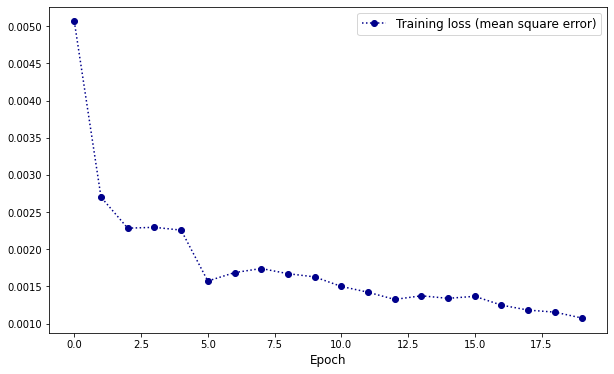

In [15]:
# Graph plot of training loss vs. number of epoch

_, p1 = plt.subplots(figsize=(10,6))
p1.plot(history.history['loss'], color='darkblue', linestyle='dotted', marker='o', label='Training loss (mean square error)')

# Parameters of the plot

p1.set_xlabel('Epoch', size='large')
p1.legend(fontsize='large')

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

# 1-day ahead predictions
In this section, we use the fitted model to generate 1-day ahead stock price predictions.

In [16]:
# Importing "load_model" function from the keras.models API (to load a model saved via model.save())
# Storing in numpy array "predicted" the one-day-ahead stock prices predicted by the model
# Storing in numpy array "real" the real stock prices contained in "test_labels"
# Putting back both arrays to the original scale and format

from keras.models import load_model

model = load_model('model_parameters.h5')

test_predicted = model.predict(test_seqs)
test_predicted = scaler.inverse_transform(test_predicted)
test_real = scaler.inverse_transform(test_labels.reshape(-1, 1))

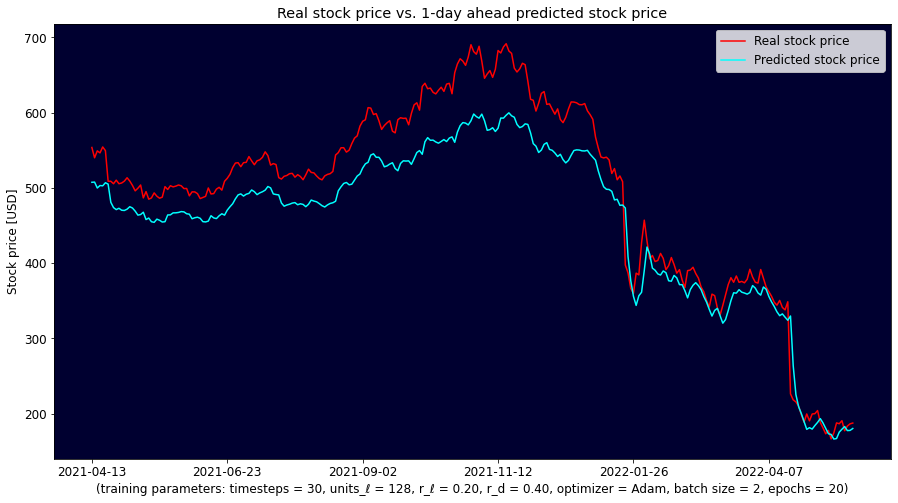

In [17]:
# Graph plot of real stock prices vs. one-day ahead predicted stock prices

_, p2 = plt.subplots(figsize=(15,8))

p2.plot(dates, test_real, color='r', label='Real stock price')
p2.plot(dates, test_predicted, color='cyan', label='Predicted stock price')

# Parameters of the plot

p2.set_title('Real stock price vs. 1-day ahead predicted stock price', size='x-large')
p2.set_ylabel('Stock price [USD]', size='large')
p2.set_xlabel('(training parameters: timesteps = %d, units_ℓ = %d, r_ℓ = %.2f, r_d = %.2f, optimizer = Adam, batch size = %d, epochs = %d)'
             % (n, units_ℓ, r_ℓ, r_d, batch_size, epochs), size='large')
p2.set_facecolor('#000030')
p2.legend(fontsize='large')

plt.xticks(np.arange(0, len(dates)+1, 50))
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

# N-days ahead predictions
In this section, we use the fitted model to generate N-days ahead stock price predictions.

In [18]:
# Setting the number "N" of days ahead predictions and the day "start_day" where to start the prediction
# Defining a list "N_predictions" containing the future N stock price predictions
# Setting as "data" the initial real stock price at start_day 

N = 10
start_day = 220
N_predictions = []
data = test_seqs[start_day: start_day+1]

# For-loop for the prediction of N consecutive stock prices after start_day

for i in range(N):
    prediction = model.predict(data)
    data = np.append(data, prediction)[1:]
    data = data.reshape(1,-1, 1)
    N_predictions.append(prediction[0][0])

# Putting the list of predictions "N_predictions" to the original scale and format

N_predictions = np.array(N_predictions).reshape(-1, 1)
N_predictions = scaler.inverse_transform(N_predictions)

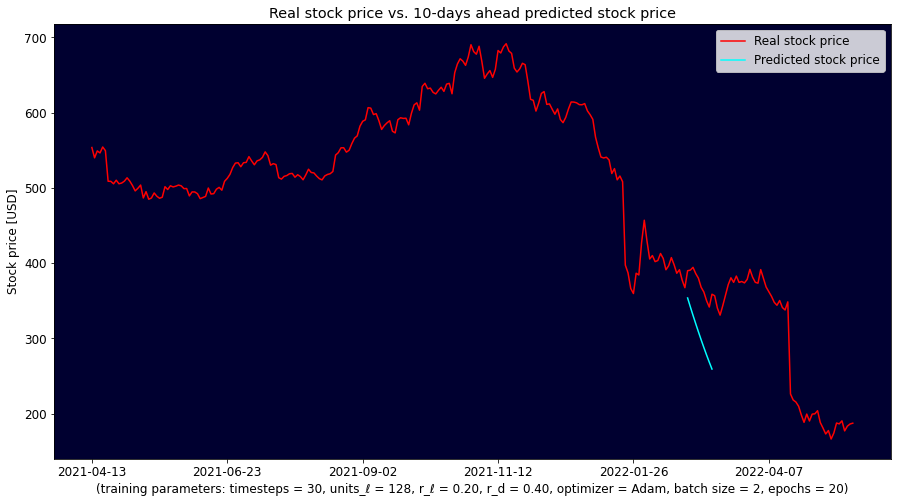

In [19]:
# Graph plot of real stock prices vs. N-days ahead predicted stock prices

_, p3 = plt.subplots(figsize=(15,8))

p3.plot(dates, test_real, color='r', label='Real stock price')
p3.plot(dates[start_day: start_day+N], N_predictions, color='cyan', label='Predicted stock price')

# Parameters of the plot

p3.set_title(('Real stock price vs. %d-days ahead predicted stock price' % N), size='x-large')
p3.set_ylabel('Stock price [USD]', size='large')
p3.set_xlabel('(training parameters: timesteps = %d, units_ℓ = %d, r_ℓ = %.2f, r_d = %.2f, optimizer = Adam, batch size = %d, epochs = %d)'
             % (n, units_ℓ, r_ℓ, r_d, batch_size, epochs), size='large')
p3.set_facecolor('#000030')
p3.legend(fontsize='large')

plt.xticks(np.arange(0, len(dates)+1, 50))
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

# Conclusion
The LSTM model seems to be accurate if one considers 1-day ahead predictions. But a more careful inspection shows that it is not the case. When one uses the model to generate N-days ahead predictions, one obtains unsatisfactory results (not able to indicate the right trend - raising or falling - of the stock price).

Two hints of explanations are the following:
- First, the parameters from the training data used to rescale the test data (maximum and minimum values) are usually not suitable for the test data. Indeed, since stock prices are not bounded from above, the value of stock prices in the future often surpass their values in the past. This can lead to scale incongruities, as one can for instance observe in the first graph.
- Second, and more importantly, the behaviour of stock prices is so complex that one cannot expect to accurately predict it using simple, deterministic models solely based on time series. The LSTM model that we used here is no exception to this rule. One has to develop more complex models (including randomness, additional types of data, other scaling methods, etc.) to get more decent predictions.